# Network-Analysis-for-Information-Retrieval

## Data 

In [54]:
import pandas as pd
from random import seed
import warnings

warnings.filterwarnings('ignore')
seed(3052000)

FILE_PREFIX = "dblp-ref-"
NB_FILES = 4

corpus = []

# Load all the files into a single dataframe
# for i in range(0, NB_FILES):
#     file = './data/' + FILE_PREFIX + str(i) + ".json"
#     data = pd.read_json(file, lines=True)
#     corpus.append(data)

# Load the lightest file
file = './data/' + FILE_PREFIX + '3' + ".json"
data = pd.read_json(file, lines=True)
corpus.append(data)

corpus = pd.concat(corpus, ignore_index=True)

In [55]:
import numpy as np

#On remplace les valeurs manquantes par des listes vides
for index, row in corpus.iterrows():
    if type(row['references']) != list:
        corpus.at[index, 'references'] = []

#Affichage des valeurs manquantes
print("Number of NAN references", corpus['references'].isna().sum())

Number of NAN references 0


In [56]:
#Remplacer les identifiants des références par les identifiants existants du corpus
for index, row in corpus.iterrows():
    for ref_index, ref in enumerate(row['references']):
        random_index = index
        while random_index == index:
            random_index = np.random.randint(0, corpus.shape[0])
        row['references'][ref_index] = corpus['id'].iloc[random_index]

In [3]:
corpus.shape

(79007, 8)

----- Abstracts -----
Mean length of Abstracts 1060.5378252168111
Max length of Abstracts 7139.0
Min length of Abstracts 60.0


----- Authors -----
Number of authors 282514
Number of unique authors 178268
Mean number of papers per author 1.5847712432966097
Number of paper per author : authors
Wei Wang                92
Yang Yang               54
Mohamed-Slim Alouini    53
Jun Wang                52
Wei Zhang               52
                        ..
Patrice Koehl            1
Saghi Nojoomi            1
Wataru Noguchi           1
Atulan Zaman             1
Eirik Abildsnes          1
Name: count, Length: 178268, dtype: int64


----- Temporal distribution -----


<Axes: >

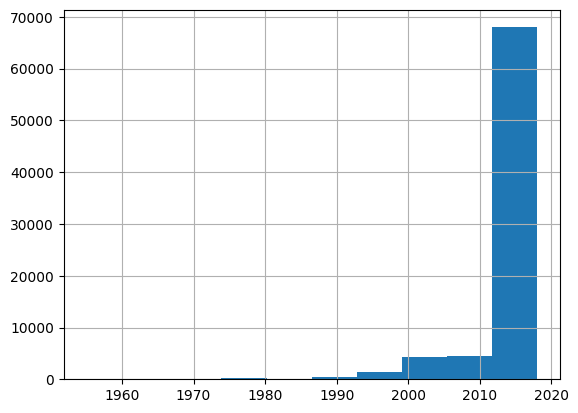

In [58]:
#Quelques statistiques sur le corpus
print("----- Abstracts -----")
print("Mean length of Abstracts", corpus['abstract'].str.len().mean())
print("Max length of Abstracts", corpus['abstract'].str.len().max())
print("Min length of Abstracts", corpus['abstract'].str.len().min())

print("\n")
print("----- Authors -----")
df_exploded = corpus.explode('authors')
print("Number of authors", len(df_exploded['authors']))
unique_authors = df_exploded['authors'].unique().tolist()
print("Number of unique authors", len(unique_authors))
print("Mean number of papers per author", df_exploded['authors'].value_counts().mean())
print("Number of paper per author :", df_exploded['authors'].value_counts())

print("\n")
print("----- Temporal distribution -----")
corpus['year'].hist(bins=10)

## Networks

In [59]:
import mpld3
import itertools
import networkx as nx
import matplotlib.pyplot as plt

NB_NODES = 2000 # nombre de nœuds à afficher en raison du grand nombre de nœuds

### Authorship Network

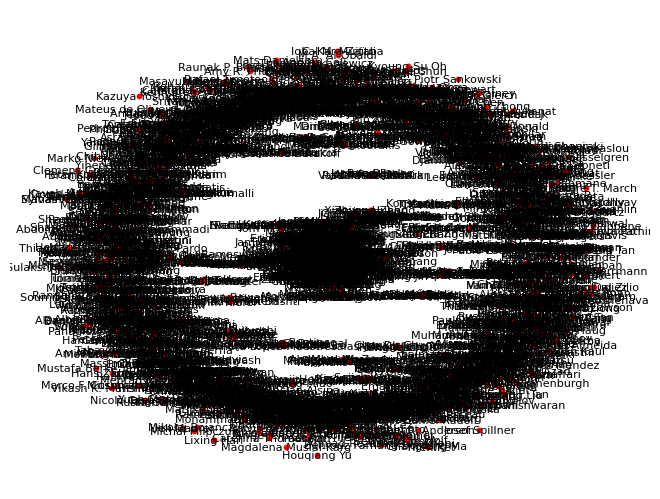

In [60]:
# Affichage du graphe
mpld3.enable_notebook()

G = nx.Graph()

for authors_list in corpus['authors']:
    G.add_nodes_from(authors_list)
    G.add_edges_from(itertools.combinations(authors_list, 2))

nodes_to_keep = list(G.nodes())[:NB_NODES]
G_filtered = G.subgraph(nodes_to_keep)

pos = nx.spring_layout(G_filtered)
nx.draw(G_filtered, pos, with_labels=True, node_size=10, node_color='red', font_size=8)

import matplotlib.pyplot as plt
plt.show()

mpld3.disable_notebook()

#### Statistical Analysis

In [61]:
#Statistiques liées au graphe des auteurs
print("Number of connected components : ", nx.number_connected_components(G_filtered))
print("Total degree : ", sum(dict(G_filtered.degree()).values()))
print("Average clustering : ", round(nx.average_clustering(G_filtered), 2))
print("Transitivity : ", round(nx.transitivity(G_filtered), 2))
print("Number of nodes : ", G_filtered.number_of_nodes())
print("Number of edges : ", G_filtered.number_of_edges())

Number of connected components :  497
Total degree :  6638
Average clustering :  0.82
Transitivity :  0.93
Number of nodes :  2000
Number of edges :  3319


#### Degree Distribution

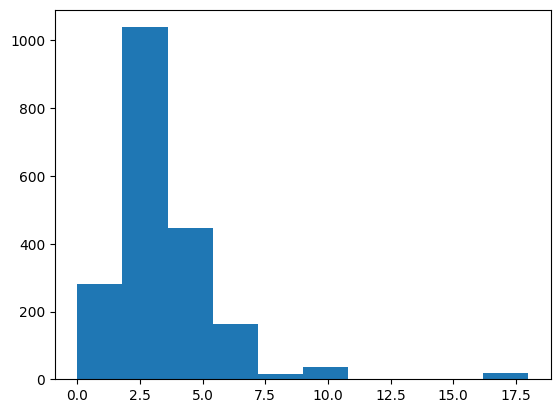

In [62]:
G_filtered.degree()
d_degree = dict(G_filtered.degree())
n, bins, patches = plt.hist(d_degree.values())
plt.show() #la majorité des auteurs ont un degré faible

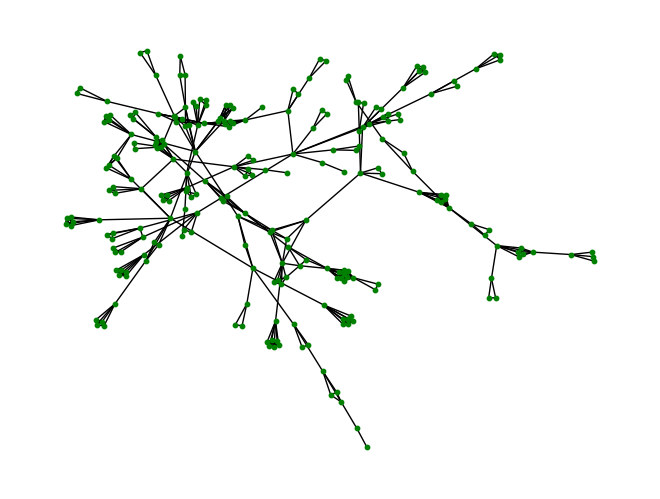

In [63]:
#Affichage du plus grand composant connexe
g_sorted = sorted(nx.connected_components(G_filtered), key=len, reverse=True)

g = G_filtered.subgraph(g_sorted[0])
pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=False, node_size=10, node_color='green', font_size=8)
plt.show()

#### Centrality Measures

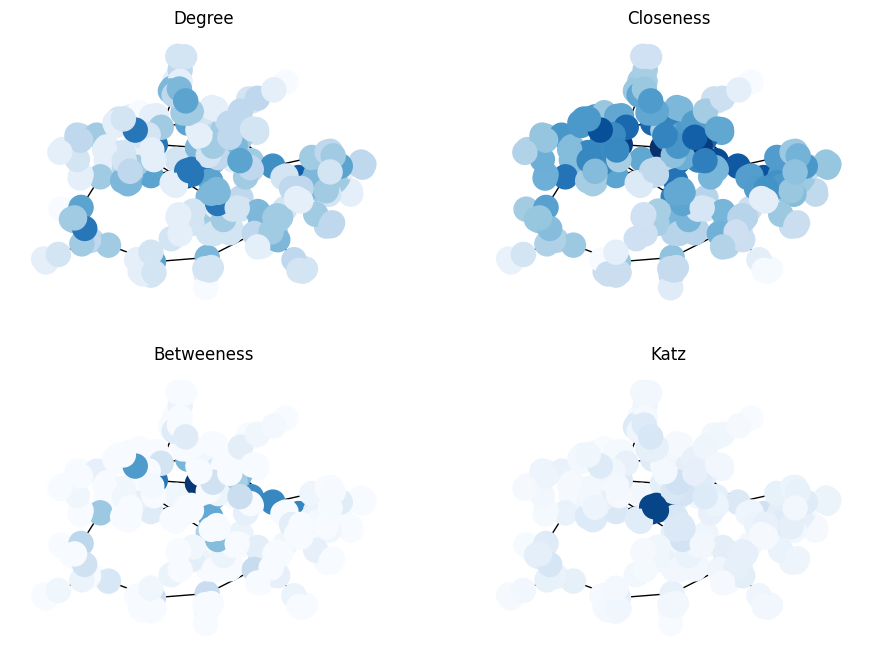

In [64]:
#On affiche les centralités des noeuds du graphe des auteurs
centralities = [nx.degree_centrality, nx.closeness_centrality, nx.betweenness_centrality, nx.katz_centrality]
centralities_names = ["Degree", "Closeness", "Betweeness", "Katz"]
val_cent = []

for c in centralities:
    val_cent.append(c(g))

my_pos = nx.spring_layout(g)

figure = plt.figure(figsize=(11, 8))
for i in range(len(centralities)):
    figure.add_subplot(2, 2, i+1)
    plt.title(centralities_names[i])
    nx.draw(g, pos = my_pos, with_labels=False, node_color=[*val_cent[i].values()], cmap=plt.cm.Blues)
plt.show() 

### Document Network

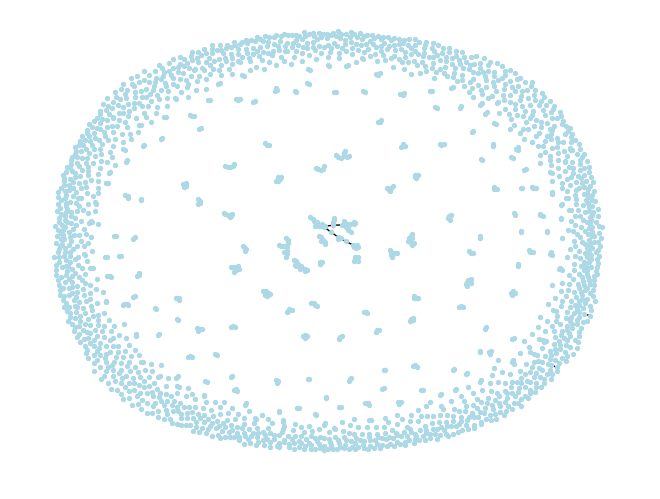

In [65]:
#On affiche le graphe des articles
G = nx.Graph()

for index, row in corpus.iterrows():
    G.add_node(row['id'])

for index, row in corpus.iterrows():
    for ref in row['references']:
        if ref in G.nodes():
            G.add_edge(row['id'], ref)
    

nodes_to_keep = list(G.nodes())[:NB_NODES]
G_filtered = G.subgraph(nodes_to_keep)

pos = nx.spring_layout(G_filtered)
nx.draw(G_filtered, pos, with_labels=False, node_size=8, node_color='lightblue', font_size=8)

plt.show()

#### Statistical Analysis

In [10]:
#Statistiques liées au graphe des articles
print("Number of connected components : ", nx.number_connected_components(G_filtered))
print("Total degree : ", sum(dict(G_filtered.degree()).values()))
print("Average clustering : ", round(nx.average_clustering(G_filtered), 2))
print("Transitivity : ", round(nx.transitivity(G_filtered), 2))
print("Number of nodes : ", G_filtered.number_of_nodes())
print("Number of edges : ", G_filtered.number_of_edges())

Number of connected components :  1580
Total degree :  840
Average clustering :  0.0
Transitivity :  0
Number of nodes :  2000
Number of edges :  420


#### Degree Distribution

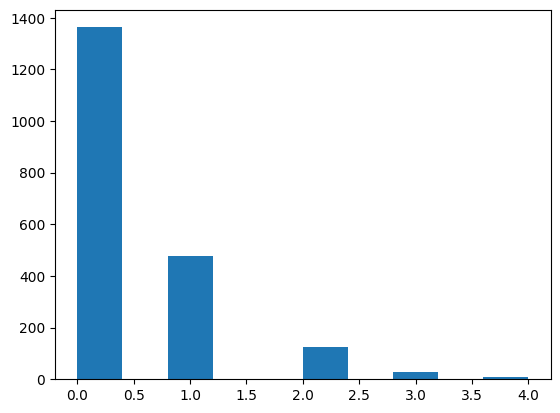

In [11]:
G_filtered.degree()
d_degree = dict(G_filtered.degree())
n, bins, patches = plt.hist(d_degree.values())
plt.show() #la majorité des articles ont un degré faible avant un fort nombre de noeuds isolés

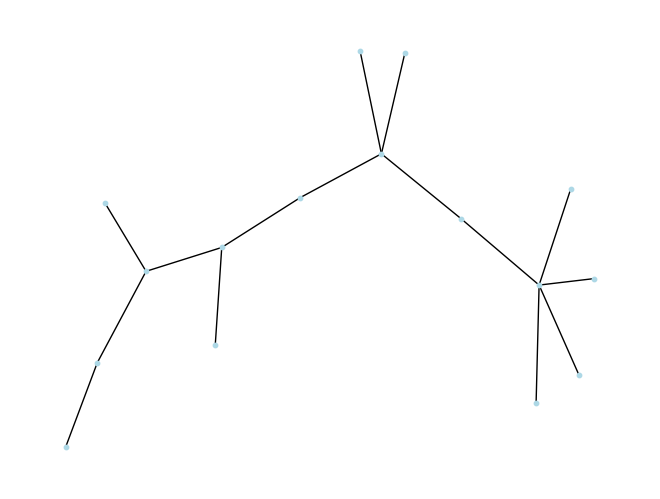

In [66]:
#Affichage du plus grand composant connexe
g_sorted = sorted(nx.connected_components(G_filtered), key=len, reverse=True)

g = G_filtered.subgraph(g_sorted[0])
pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=False, node_size=10, node_color='lightblue', font_size=8)
plt.show()

#### Centrality Measures

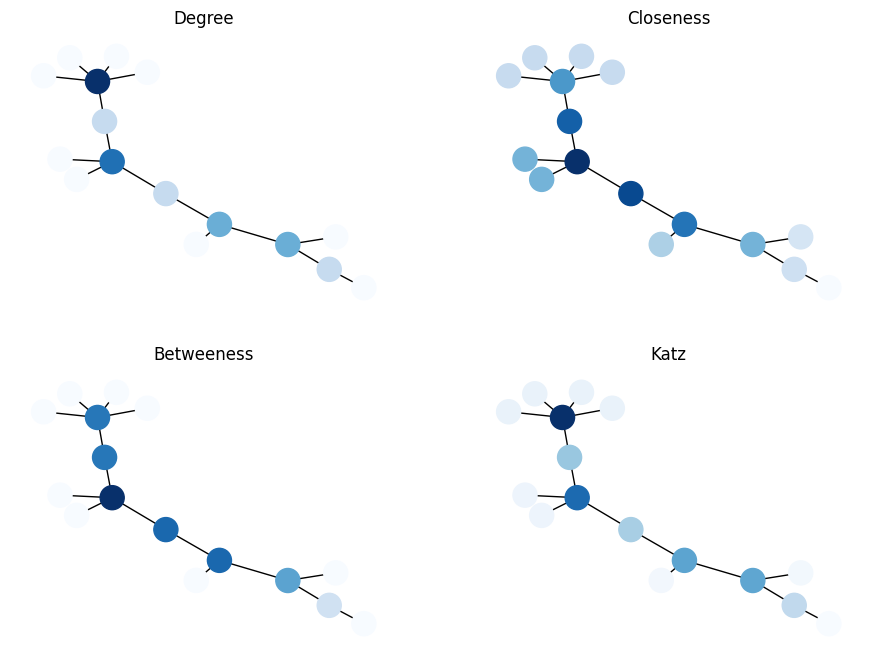

In [67]:
#On affiche les centralités des noeuds du graphe des articles
centralities = [nx.degree_centrality, nx.closeness_centrality, nx.betweenness_centrality, nx.katz_centrality]
centralities_names = ["Degree", "Closeness", "Betweeness", "Katz"]
val_cent = []

for c in centralities:
    val_cent.append(c(g))

my_pos = nx.spring_layout(g)

figure = plt.figure(figsize=(11, 8))
for i in range(len(centralities)):
    figure.add_subplot(2, 2, i+1)
    plt.title(centralities_names[i])
    nx.draw(g, pos = my_pos, with_labels=False, node_color=[*val_cent[i].values()], cmap=plt.cm.Blues)
plt.show()

## Search Engine

### Preprocessing

In [14]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PXDD4216\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PXDD4216\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PXDD4216\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [68]:
##Nombre de Nan dans les abstracts
print("Number of NAN abstracts", corpus['abstract'].isna().sum())

##On les retire
corpus = corpus.dropna(subset=['abstract'])

Number of NAN abstracts 34037


In [69]:
#Création d'une fonction de prétraitement des abstracts
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

corpus['abstract'] = corpus['abstract'].apply(preprocess)

### Vectorization

In [70]:
#On affiche les mots les plus fréquents
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(corpus['abstract'])
features_hp = vectorizer.get_feature_names_out()

In [71]:
from scipy.sparse import find, csr_matrix
import pandas as pd

# cette fonction permet d'afficher une "jolie" représentation du vecteur v
# ARGS :
#   v : le vecteur à afficher (par ex. une ligne de la matrice X)
#   features : le vocabulaire
#   top_n : le nombre de mots maximum à afficher
def print_feats(v, features, top_n = 30):
    _, ids, values = find(v)
    feats = [(ids[i], values[i], features[ids[i]]) for i in range(len(list(ids)))]
    top_feats = sorted(feats, key=lambda x: x[1], reverse=True)[0:top_n]
    return pd.DataFrame({"word" : [t[2] for t in top_feats], "value": [t[1] for t in top_feats]})  

In [72]:
n_docs, n_terms = X.shape

# on fait la somme sur toutes les lignes pour chacun des mots
tf_sum = X.sum(axis=0)
tf_sum = tf_sum.tolist()[0] # conversion en liste

print_feats(tf_sum, features_hp)

word  value
0         use  46895
1      propos  37034
2       model  32944
3      system  32247
4        data  30924
5      method  29521
6       paper  28360
7      result  27070
8   algorithm  24702
9     network  24259
10    perform  22910
11       base  21848
12    problem  20036
13   approach  18689
14       show  18309
15    present  16742
16      studi  15917
17       time  15703
18     differ  15503
19     comput  15299
20     inform  15274
21     provid  14925
22     design  14307
23    process  13938
24       user  13899
25     applic  13875
26    develop  13414
27       also  13094
28       imag  13045
29      optim  12587

In [73]:
from scipy.linalg import norm

# fonction calculant le cosinus entre deux vecteurs
def cosinus(i, j):
        # numérateur : <i.j>
    num = i.dot(j.transpose())[0,0]
        # dénominateur : ||i||_2 * ||j||_2
    den = norm(i.todense()) * norm(j.todense())
    if (den>0): # on vérifie que le dénominateur n'est pas nul
        return (num/den)
    else:
        return 0

In [74]:
print(print_feats(X[5], features_hp, top_n=30))
print('----------------------------------------')
print(print_feats(X[10], features_hp, top_n=30))

          word  value
0         text      6
1      contain      5
2     recognit      5
3       result      3
4         code      2
5       detect      2
6    dimension      2
7      identif      2
8       propos      2
9         rate      2
10      achiev      1
11       addit      1
12     automat      1
13  background      1
14        base      1
15        bodi      1
16    challeng      1
17       color      1
18      compon      1
19     connect      1
20     coverag      1
21    demonstr      1
22       error      1
23        even      1
24  experiment      1
25        form      1
26     generat      1
27      global      1
28        high      1
29        make      1
----------------------------------------
             word  value
0        approach      3
1          method      3
2          appear      2
3          compar      2
4          record      2
5             use      2
6         variant      2
7          applic      1
8         complex      1
9        demonstr      1
10

In [75]:
similarity_5_10 = round(cosinus(X[5], X[10]) * 100,2)
print("Similarity between 5 and 10 : ", similarity_5_10, "%")

Similarity between 5 and 10 :  4.02 %


In [76]:
# Vectorisation des abstracts
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(corpus['abstract'])
features_hp = vectorizer.get_feature_names_out()

n_docs, n_terms = X.shape

In [77]:
# similarité entre les documents
def similarity(input, X):
    input = preprocess(input)
    input = vectorizer.transform([input])
    sim = []
    for i in range(n_docs):
        sim.append(cosinus(input, X[i]))
    return sim

In [78]:
def most_similar(input, X, corpus, top_n=10):    
    sim = similarity(input, X)
    sim_sorted = sorted(enumerate(sim), key=lambda x: x[1], reverse=True)
    for i in range(top_n):
        print("Document ", sim_sorted[i][0], " : ", corpus['title'].iloc[sim_sorted[i][0]], " (", round(sim_sorted[i][1],2)*100, "%)")

In [79]:
# Affichage des documents les plus similaires par rapport à 'Machine Learning'
most_similar("machine learning", X, corpus, top_n=10)

Document  4173  :  On the feasibility of an embedded machine learning processor for intrusion detection  ( 72.0 %)
Document  44550  :  Infrastructure for Usable Machine Learning: The Stanford DAWN Project  ( 64.0 %)
Document  27692  :  Machine learning and systems for the next frontier in formal verification  ( 63.0 %)
Document  28972  :  The 2003 learning classifier systems bibliography  ( 63.0 %)
Document  27044  :  Hyperparameter optimization to improve bug prediction accuracy  ( 62.0 %)
Document  2985  :  Machine Learning Meets Databases  ( 61.0 %)
Document  34438  :  In vitro molecular machine learning algorithm via symmetric internal loops of DNA  ( 61.0 %)
Document  42712  :  The optimal crowd learning machine  ( 59.0 %)
Document  30622  :  Design and implementation of low-level machine learning API and API server  ( 56.99999999999999 %)
Document  12814  :  Ontology knowledge-based framework for machine learning concept  ( 56.99999999999999 %)


In [43]:
#Même chose avec spacy
import spacy

nlp = spacy.load("en_core_web_md")

def similarity(input, corpus):
    input = nlp(preprocess(input))
    sim = []
    for doc in corpus['abstract']:
        doc = nlp(doc)
        sim.append(input.similarity(doc))
    return sim


In [80]:
#Utilisation de Doc2Vec pour trouver les documents les plus similaires à la recherche
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

min_docs = 4
tagged_docs = []
nbw_docs = []

for i, abstract in enumerate(corpus['abstract']):
    if len(abstract.split()) > min_docs:
        tagged_docs.append(TaggedDocument(words=word_tokenize(abstract), tags=[i]))
        nbw_docs.append(len(abstract.split()))

In [35]:
len(tagged_docs)
tagged_docs[0:4]

[TaggedDocument(words=['adaboost', 'algorithm', 'base', 'haarlik', 'featur', 'achiev', 'high', 'accuraci', '95', 'object', 'detect', 'meanwhil', 'massiv', 'comput', 'power', 'need', 'implement', 'cascad', 'classifi', 'involv', 'adaboost', 'detect', 'solv', 'problem', 'sever', 'dedic', 'hardwar', 'solut', 'propos', 'realtim', 'applic', 'work', 'novel', 'heterogen', 'architectur', 'adaboost', 'detector', 'present', 'architectur', 'achiev', 'higher', 'perform', 'consum', 'fewer', 'hardwar', 'resourc', 'combin', 'integr', 'arm', 'cortexa9', 'processor', 'dedic', 'acceler', 'architectur', 'configur', 'realiz', 'various', 'object', 'detect', 'simpli', 'load', 'differ', 'paramet', '2d', 'parallel', 'involv', 'acceler', 'unit', 'combin', 'bring', 'flexibl', 'scheme', 'implement', 'xilinx', 'zc702', 'platform', 'experi', 'result', 'show', '40', 'qvga', 'frame', 'per', 'second', 'achiev', 'realtim', 'face', 'detect', 'acceler', 'achiev', '13', 'time', 'improv', 'opencv', 'implement', 'standalon'

In [81]:
#Création du modèle Doc2Vec
dim_d2v = 10

model_doc2vec = Doc2Vec(tagged_docs, vector_size=dim_d2v, window=3, epochs=50)
model_doc2vec.train(tagged_docs, total_examples=model_doc2vec.corpus_count, epochs=model_doc2vec.epochs)

In [82]:
#Test avec la recherche "data"
test_doc = word_tokenize("data".lower())
test_doc_vector = model_doc2vec.infer_vector(test_doc)
res = model_doc2vec.dv.most_similar(positive = [test_doc_vector])
print(res)

[(28557, 0.794924795627594), (35227, 0.7817708849906921), (2835, 0.7632768750190735), (3503, 0.7632378339767456), (10452, 0.7599087357521057), (25135, 0.7432098388671875), (44530, 0.7343931198120117), (3060, 0.7331286072731018), (4906, 0.7316511869430542), (16349, 0.7299553155899048)]


In [83]:
for i in range(10):
    print("Document ", res[i][0], " : ", corpus['title'].iloc[res[i][0]], " (", round(res[i][1],2)*100, "%)")

Document  28557  :  Clustering Multivariate Data Streams by Correlating Attributes using Fractal Dimension  ( 79.0 %)
Document  35227  :  Visual-Based Analysis of Classification Measures with Applications to Imbalanced Data  ( 78.0 %)
Document  2835  :  User profile extraction engine  ( 76.0 %)
Document  3503  :  Usability of Visibly Adaptive Smartphone keyboard layouts  ( 76.0 %)
Document  10452  :  Data fusion without knowledge of the ground truth using Tseltin-like Automata  ( 76.0 %)
Document  25135  :  A service computing manifesto: the next 10 years  ( 74.0 %)
Document  44530  :  A multi-scale deep quad tree based feature extraction method for the recognition of isolated handwritten characters of popular indic scripts  ( 73.0 %)
Document  3060  :  Bayesian multi-topic microarray analysis with hyperparameter reestimation  ( 73.0 %)
Document  4906  :  Advantage of integration in big data: Feature generation in multi-relational databases for imbalanced learning  ( 73.0 %)
Document  

In [84]:
#Importation des librairies nécessaires pour S-BERT
import torch # the main pytorch library
import torch.nn.functional as f # the sub-library containing different functions for manipulating with tensors

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [85]:
#Utilisation de S-BERT pour trouver les documents les plus similaires à la recherche
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
model = model.to(device)

bert_abstract = corpus['abstract'].apply(lambda x: x[:512])

# keep half of the abstracts
bert_abstract = bert_abstract.sample(frac=0.25)

embeddings = model.encode(bert_abstract.values, convert_to_tensor=True)

In [86]:
#Calcul de la similarité cosinus avec embeddings de S-BERT
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity_matrix = cosine_similarity(embeddings, embeddings)

def most_similar_bert(input, embeddings, top_n=10):
    input = model.encode([input], convert_to_tensor=True)
    sim = cosine_similarity(input, embeddings)
    sim_sorted = sorted(enumerate(sim[0]), key=lambda x: x[1], reverse=True)
    for i in range(top_n):
        print("Document ", sim_sorted[i][0], " : ", bert_abstract.iloc[sim_sorted[i][0]][0:100], " (", round(sim_sorted[i][1],2)*100, "%)")

most_similar_bert("data", embeddings, top_n=10)

Document  6213  :  human expert amount sensori data deal moment human brain analysi data also start synthes new inform   ( 54.00000214576721 %)
Document  9325  :  remark number real applic dynam scenario drive novel abil generat gather inform nowaday massiv amoun  ( 52.99999713897705 %)
Document  4726  :  abil synthes sensori data preserv specif statist properti real data tremend implic data privaci big   ( 51.99999809265137 %)
Document  2157  :  market data environ data reason deal data market data larg hard analyz effici analyz organ larg scal  ( 51.99999809265137 %)
Document  5310  :  correl analysi alway key techniqu understand data howev tradit method applic whole data set provid g  ( 50.999999046325684 %)
Document  10107  :  carat project start 2012 collect 15 tb data 850000 mobil user world project us apach thrift transmit  ( 50.999999046325684 %)
Document  848  :  open data increas transpar account countri govern lead free inform share stimul new innov paper anal  ( 50.0 %)
Doc

## Classification

In [87]:
#Création d'une fonction pour la recherche de documents
import numpy as np

corpus['venue'].replace('', np.nan, inplace=True)
corpus = corpus.dropna(subset=['venue'])

stop_words_venues = [
    "applied",
    "arxiv",
    "conference",
    "information",
    "international",
    "journal",
    "knowledge",
    "research",
    "symposium",
    "acm",
    "advances",
    "lectures",
    "notes",
    "note"
]

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [t for t in tokens if t not in stop_words_venues]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

corpus['venue'] = corpus['venue'].apply(preprocess)
    
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus['venue'])
features_venues = vectorizer.get_feature_names_out()

n_docs, n_terms = X.shape

# on fait la somme sur toutes les lignes pour chacun des mots
tf_sum = X.sum(axis=0)
tf_sum = tf_sum.tolist()[0] # conversion en liste

print_feats(tf_sum, features_venues)

word  value
0      comput  11087
1      scienc   5323
2      lectur   3633
3      system   3538
4    communic   2911
5        ieee   2700
6     network   1822
7     pattern   1505
8    recognit   1503
9       engin   1477
10     applic   1459
11  technolog   1349
12   transact   1302
13    process   1257
14     vision   1172
15      robot   1164
16       data   1056
17     theori   1038
18   intellig   1034
19   mathemat   1004
20      learn    994
21   wireless    962
22     global    955
23   cybernet    939
24     sensor    903
25     design    871
26      autom    818
27     signal    749
28        man    743
29   informat    741

<Axes: xlabel='category'>

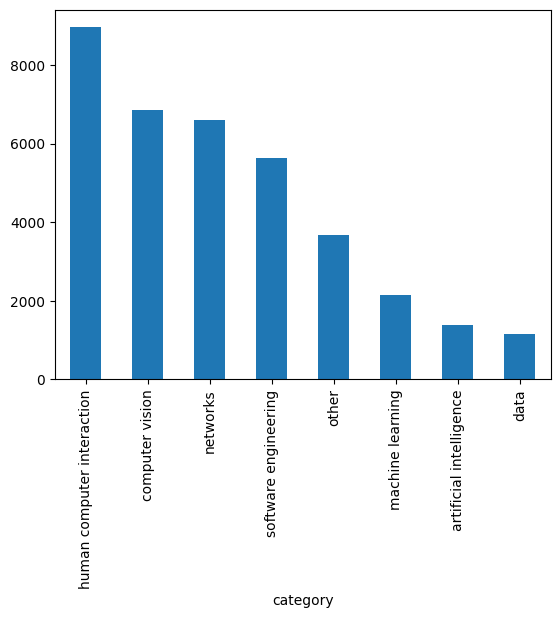

In [88]:
categories = {
    "artificial intelligence" : ["artifici","intellig", "theori", "electron"],
    "computer vision": ["comput", "imag","ieee", "manag", "design", "vision", "recognit", "pattern"],
    "data" : ["data", "analysi", "transact"],
    "human computer interaction": ["communic","robot", "scienc", "human", "sensor"],
    "machine learning": ["model","mathemat", "language", "logic", "algorithm", "learn"],
    "networks": ["network", "system", "process", "secur","wireless","cybernet"],
    "software engineering": ["engin", "technolog", "applic", "softwar", "program", "informat"]
}

# create a new column for each category if abstract contains the category
corpus["category"] = ""

for category, keywords in categories.items():
    for keyword in keywords:
        corpus.loc[corpus['venue'].str.contains(keyword), "category"] = category

# replace empty category with "other"
corpus["category"].replace("", "other", inplace=True)

corpus["category"].value_counts().sum()
corpus["category"].value_counts().plot(kind='bar')


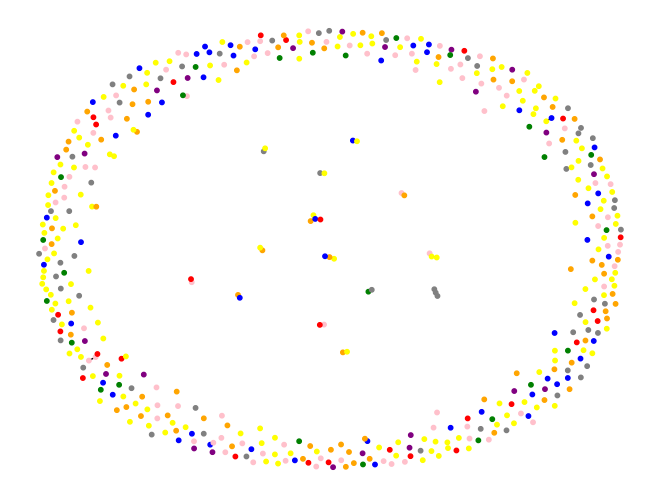

In [89]:
#Affichage du graphe des articles par catégorie générée
from random import randint
mpld3.enable_notebook()
G = nx.Graph()
NB_NODES = 500

for index, row in corpus.iterrows():
    G.add_node(row['id'], category=row['category'])

for index, row in corpus.iterrows():
    for ref in row['references']:
        if ref in G.nodes():
            G.add_edge(row['id'], ref)

categories_color = {
    "artificial intelligence": "red",
    "computer vision": "blue",
    "data": "green",
    "human computer interaction": "yellow",
    "machine learning": "purple",
    "networks": "orange",
    "software engineering": "pink",
    "other": "grey"
}

sub_G = G.subgraph(list(G.nodes())[:NB_NODES])

# # # create a color map for the nodes
color_map = []

for node in sub_G:
    node_category = sub_G.nodes[node]['category']
    color_map.append(categories_color[node_category])

# # # draw the graph
pos = nx.spring_layout(sub_G)
nx.draw(sub_G, pos, node_color=color_map, with_labels=False, node_size=10)

plt.show()

### Classification of Documents

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(corpus['abstract'], corpus['category'], test_size=0.3, random_state=42)

In [52]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score

model = SentenceTransformer('all-MiniLM-L6-v2')

X_train = model.encode(X_train.values)
X_test = model.encode(X_test.values)

KeyboardInterrupt: 

In [90]:
# tf idf
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(corpus['abstract'])

X_train, X_test, y_train, y_test = train_test_split(X, corpus['category'], test_size=0.3, random_state=42)

In [91]:
X_train

<25511x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1255453 stored elements in Compressed Sparse Row format>

In [92]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy_score("Logistic Regression : ", y_test, y_pred)

TypeError: too many positional arguments

In [ ]:
from sklearn.svm import SVC

model = SVC(kernel='poly', degree=2)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy_score("SVM : ", y_test, y_pred)

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(solver='adam', alpha=1e-5, max_iter=500)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy_score("MLP : ", y_test, y_pred)

In [93]:
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv

import torch.nn.functional as F
from tqdm import tqdm

In [94]:
# convert networkx graph to pytorch geometric graph
from torch_geometric.utils import convert

# add embeddings to the graph named "x"
for index, row in corpus.iterrows():
    if row['id'] in sub_G.nodes():
        sub_G.nodes[row['id']]['x'] = embeddings[index]
data = convert.from_networkx(sub_G)
data.y = data.category

del data.category
del data.embeddings

# create a mask for the train, validation and test set
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_mask[:int(data.num_nodes*0.8)] = 1
val_mask[int(data.num_nodes*0.8):int(data.num_nodes*0.9)] = 1
test_mask[int(data.num_nodes*0.9):] = 1

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [95]:
# label encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data.y = le.fit_transform(np.array(data.y).reshape(-1, 1))

# convert data.y to tensor
data.y = torch.tensor(data.y, dtype=torch.long)

In [96]:
def print_accuracy(nom_algo, truth_train, pred_train, truth_test, pred_test):
    print(nom_algo + " : ")
    acc_app = np.sum(pred_train == truth_train) / float(len(pred_train))
    print(f"  - réussite (accuracy) apparente : {acc_app:.1%}")
    acc_gen = np.sum(pred_test == truth_test) / float(len(pred_test))
    print(f"  - réussite (accuracy) en généralisation : {acc_gen:.1%}")    

In [98]:
class MyGCN(torch.nn.Module):
    def __init__(self, d, n_feat):
        super().__init__()
        self.d = d
        # Initialisation des couches de convolutions
        self.conv1 = GCNConv(n_feat, 16)        
        self.conv2 = GCNConv(16, corpus['category'].nunique())

    def forward(self):
        # Récupération des données
        x, edge_index, edge_attr = self.d, data.edge_index, data.edge_attr
        # Premiere convolution
        x = F.dropout(x, training=self.training)
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        # Deuxième convolution
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        # Softmax
        return F.log_softmax(x, dim=1)

In [99]:
class Training():
    
    def __init__(self, m, o):
        self.model = m
        self.optim = o
    
    def train(self, nb_epochs=50):
        progress_bar = tqdm(range(nb_epochs))
        for epoch in progress_bar:
            train_acc, test_acc = self.test()
            progress_bar.set_description(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Test: {test_acc:.4f}')        
            self.model.train() ## mode "train"
            self.optim.zero_grad()
            F.nll_loss(self.model()[data.train_mask], data.y[data.train_mask]).backward()
            self.optim.step()
        
    def eval(self):
        self.model.eval()
        
    def forward(self):
        return self.model.forward()

    # retourne l'accuracy sur les données d'entraînement (train) et sur le test
    @torch.no_grad()
    def test(self):
        self.model.eval()  ## mode "eval" (pas de dropout)
        log_probs, accs = self.model(), []
        for _, mask in data('train_mask', 'test_mask'):
            pred = log_probs[mask].max(1)[1]
            acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
            accs.append(acc)
        return accs
    
    @torch.no_grad()
    def print_eval(self, name):
        self.model.eval()  ## mode "eval" (pas de dropout)        
        log_probs = self.model()
        pred_train = np.array(log_probs[data.train_mask].max(1)[1])
        pred_test = np.array(log_probs[data.test_mask].max(1)[1])
        print_accuracy(name, data.y[data.train_mask].tolist(), pred_train, data.y[data.test_mask].tolist(), pred_test)

In [100]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_GCN1, data = MyGCN(data.x, data.num_features).to(device), data.to(device) # Chargement du modèle et des données en mémoire (VRAM ou RAM en fonction de la présence ou non d'un gpu)
optimizer_GCN1 = torch.optim.Adam(model_GCN1.parameters(), lr=0.01, weight_decay=5e-3)    

In [101]:
m1 = Training(model_GCN1, optimizer_GCN1)
m1.train(nb_epochs=200)

Epoch: 199, Train: 0.5425, Test: 0.3000: 100%|██████████| 200/200 [00:03<00:00, 54.99it/s]


In [102]:
m1.print_eval("GCN with features")

GCN with features : 
  - réussite (accuracy) apparente : 52.8%
  - réussite (accuracy) en généralisation : 32.0%


## Clustering

In [110]:
#spectral clustering with just the abstracts ofg = G_filtered.subgraph(g_sorted[0])
from sklearn.cluster import SpectralClustering
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

X = model.encode(corpus['abstract'].values, convert_to_tensor=True)

sc = SpectralClustering(n_clusters=8, affinity='nearest_neighbors', n_neighbors=10)
sc.fit(X)


KeyboardInterrupt: 

In [ ]:
#spectral clustering with tfidf

clustering = SpectralClustering(n_clusters=10, assign_labels="discretize", random_state=0).fit(X)

corpus['cluster'] = clustering.labels_

corpus['cluster'].value_counts()


In [103]:
#clustering kmeans with doc2Vec
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8, random_state=0).fit(model_doc2vec.dv.vectors)

corpus['cluster'] = kmeans.labels_

corpus['cluster'].value_counts()


ValueError: Length of values (44970) does not match length of index (36445)

In [ ]:
#print categorie most present in each group 
for i in range(8):
    print("Cluster ", i, " : ", corpus[corpus['cluster'] == i]['category'].value_counts().idxmax())

In [107]:
#calcul ari for kmeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

corpus['category'] = pd.Categorical(corpus['category'])
corpus['category'] = corpus['category'].cat.codes

print("adjusted rand score :", adjusted_rand_score(corpus['cluster'], corpus['category']))
print("adjusted mutual info score :", adjusted_mutual_info_score(corpus['cluster'], corpus['category']))

adjusted rand score : 0.0167194115590851
adjusted mutual info score : 0.03614758741085514


In [104]:
#clustering kmeans with tfidf
kmeans = KMeans(n_clusters=8, random_state=0).fit(X)

corpus['cluster'] = kmeans.labels_

corpus['cluster'].value_counts()

cluster
4    9823
0    7582
1    5712
3    4458
6    3583
5    2397
2    1739
7    1151
Name: count, dtype: int64

In [105]:
#print categorie most present in each group 
for i in range(8):
    print("Cluster ", i, " : ", corpus[corpus['cluster'] == i]['category'].value_counts().idxmax())

Cluster  0  :  human computer interaction
Cluster  1  :  human computer interaction
Cluster  2  :  computer vision
Cluster  3  :  networks
Cluster  4  :  human computer interaction
Cluster  5  :  human computer interaction
Cluster  6  :  computer vision
Cluster  7  :  human computer interaction


In [108]:
corpus['category'] = pd.Categorical(corpus['category'])
corpus['category'] = corpus['category'].cat.codes

print("adjusted rand score :", adjusted_rand_score(corpus['cluster'], corpus['category']))
print("adjusted mutual info score :", adjusted_mutual_info_score(corpus['cluster'], corpus['category']))


adjusted rand score : 0.0167194115590851
adjusted mutual info score : 0.03614758741085514


In [ ]:
#use block models
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=8).fit(X)

corpus['cluster'] = clustering.labels_

corpus['cluster'].value_counts()